In [1]:
import os 
import datetime

def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n" + "=========="*8 + "%s" % nowtime)
    

## DNN二分类
### 1. 准备数据

In [2]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import torch
from torch import nn

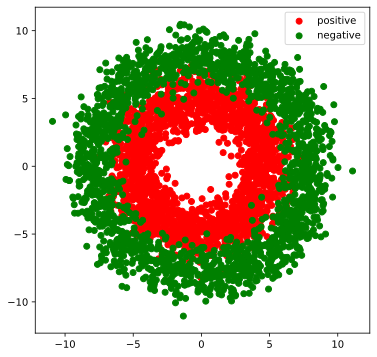

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# 样本数量
n_positive, n_negative = 2000, 2000

# 生成正样本, 小圆环分布, label = 1
r_p = 5.0 + torch.normal(0.0, 1.0, size = [n_positive, 1]) # 离散正态分布
theta_p = 2 * np.pi * torch.rand([n_positive, 1])
Xp = torch.cat([r_p * torch.cos(theta_p), r_p * torch.sin(theta_p)], axis = 1)
Yp = torch.ones_like(r_p)

# 生成负样本, 大圆环分布, label = 0
r_n = 8.0 + torch.normal(0.0, 1.0, size = [n_negative, 1])
theta_n = 2 * np.pi * torch.rand([n_negative, 1])
Xn = torch.cat([r_n * torch.cos(theta_n), r_n * torch.sin(theta_n)], axis = 1)
Yn = torch.zeros_like(r_n)

# 汇总样本
X = torch.cat([Xp, Xn], axis = 0)
Y = torch.cat([Yp, Yn], axis = 0)

# 可视化
plt.figure(figsize=(6, 6))
plt.scatter(Xp[:, 0].numpy(), Xp[:, 1].numpy(), c = 'r')
plt.scatter(Xn[:, 0].numpy(), Xn[:, 1].numpy(), c = 'g')
plt.legend(['positive', 'negative'])

In [4]:
# 构建数据管道迭代器
def data_iter(features, labels, batch_size):
    num_examples = len(features)
    indices = list(range(num_examples))
    np.random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        indexs = torch.LongTensor(indices[i : min(i + batch_size, num_examples)])
        yield features.index_select(0, indexs), labels.index_select(0, indexs)

In [5]:
# 测试数据管道
BATCH_SIZE = 8
(features, labels) = next(data_iter(X, Y, BATCH_SIZE))
print(features)
print(labels)

tensor([[ 3.1503, -2.6106],
        [ 4.2954, -6.3202],
        [ 1.2529,  4.9640],
        [ 5.9454, -7.1408],
        [-3.6832, -0.3982],
        [ 4.9342,  1.5452],
        [ 2.1844, -9.0102],
        [-8.9162, -1.4366]])
tensor([[1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.]])


### 2. 定义模型

In [6]:
class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.w1 = nn.Parameter(torch.randn(2, 4))
        self.b1 = nn.Parameter(torch.zeros(1, 4))
        self.w2 = nn.Parameter(torch.randn(4, 8))
        self.b2 = nn.Parameter(torch.zeros(1, 8))
        self.w3 = nn.Parameter(torch.randn(8, 1))
        self.b3 = nn.Parameter(torch.zeros(1, 1))
    
    # 正向传播
    def forward(self, x):
        x = torch.relu(x @ self.w1 + self.b1)
        x = torch.relu(x @ self.w2 + self.b2)
        y = torch.sigmoid(x @ self.w3 + self.b3)
        return y
    
    # 损失函数：二元交叉熵
    def loss_func(self, y_pred, y_true):
        
        # 用torch.clamp将预测值限制在1e-7以上, 1-(1e-7)以下，避免log(0)错误
        eps = 1e-7 # no space!!
        y_pred = torch.clamp(y_pred, eps, 1.0-eps)
        
        # binary cross entrophy 
        bce = - y_true * torch.log(y_pred) - (1 - y_true) * torch.log(1 - y_pred)
        
        return torch.mean(bce)
    
    # 评估指标 (准确率)
    def metric_func(self, y_pred, y_true):
        y_pred = torch.where(y_pred > 0.5, 
                             torch.ones_like(y_pred, dtype = torch.float32),
                             torch.zeros_like(y_pred, dtype = torch.float32))
        acc = torch.mean(1 - torch.abs(y_true - y_pred))
        return acc 

model = DNNModel()

In [7]:
# 测试模型结构

BATCH_SIZE = 20
(features, labels) = [i for i in data_iter(X, Y, BATCH_SIZE)][0]
predictions = model(features)
loss = model.loss_func(y_pred=predictions, y_true=labels) # 注意参数顺序
metric = model.metric_func(predictions, labels)

print("init loss:", loss.item())
print("init metric:", metric.item())

init loss: 4.827916145324707
init metric: 0.44999998807907104


In [8]:
len(list(model.parameters()))

6

### 3. 训练模型

In [9]:
def train_step(model, features, labels, learning_rate):
    # 正向传播求损失
    predictions = model.forward(features)
    loss = model.loss_func(predictions, labels)
    metric = model.metric_func(predictions, labels)
    
    # 反向传播求梯度
    loss.backward()
    
    # 梯度下降更新参数
    for param in model.parameters():
        param.data = (param.data - learning_rate*param.grad.data)
    
    # 梯度清零
    model.zero_grad()
    
    return loss.item(), metric.item()

In [10]:
def train_model(model, epochs):
    for epoch in range(1, epochs+1):
        loss_list, metric_list = [], []
        for features, labels in data_iter(X, Y, BATCH_SIZE):
            lossi, metrici = train_step(model, features, labels, lr)
            loss_list.append(lossi)
            metric_list.append(metrici)
        loss = np.mean(loss_list)
        metric = np.mean(metric_list)
        
        if epoch%100 == 0:
            printbar()
            print("epoch = ", epoch, "loss = ", loss, "metric = ", metric)

In [11]:
EPOCHS = 1000  
lr = 0.01
train_model(model, epochs=EPOCHS)


================================================================================2020-12-10 15:47:37
epoch =  100 loss =  0.18409594929311424 metric =  0.9309999933838844

================================================================================2020-12-10 15:47:50
epoch =  200 loss =  0.17800115958787502 metric =  0.9297499933838844

================================================================================2020-12-10 15:48:03
epoch =  300 loss =  0.1754655159311369 metric =  0.9322499933838845

================================================================================2020-12-10 15:48:17
epoch =  400 loss =  0.17471680195070804 metric =  0.9327499917149544

================================================================================2020-12-10 15:48:30
epoch =  500 loss =  0.17297297226265074 metric =  0.9322499936819076

================================================================================2020-12-10 15:48:44
epoch =  600 loss =  0.1725488979741931 metri

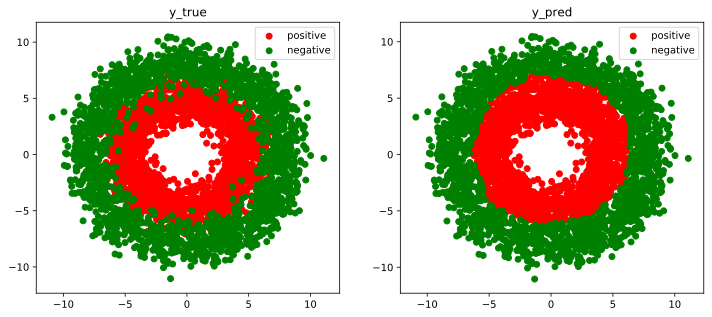

In [12]:
# 结果可视化

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
ax1.scatter(Xp[:, 0], Xp[:, 1], c = "r")
ax1.scatter(Xn[:, 0], Xn[:, 1], c = "g")
ax1.legend(["positive", "negative"]);
ax1.set_title("y_true");

Xp_pred = X[torch.squeeze(model.forward(X)>=0.5)]
Xn_pred = X[torch.squeeze(model.forward(X)<0.5)]

ax2.scatter(Xp_pred[:, 0], Xp_pred[:, 1],c = "r")
ax2.scatter(Xn_pred[:, 0], Xn_pred[:, 1],c = "g")
ax2.legend(["positive", "negative"]);
ax2.set_title("y_pred");

In [13]:
# torch.clamp(input, min, max, *, out=None) → Tensor
# Clamp all elements in input into the range [ min, max ] and return a resulting tensor:
torch.manual_seed(0)
a = torch.randn([1, 5])
clamp = torch.clamp(a, min = -0.5, max = 0.5)
print(a)
print(clamp)

tensor([[ 1.5410, -0.2934, -2.1788,  0.5684, -1.0845]])
tensor([[ 0.5000, -0.2934, -0.5000,  0.5000, -0.5000]])


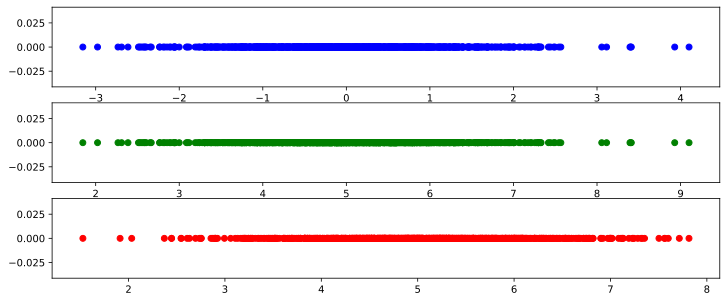

In [14]:
# 离散正态分布

torch.manual_seed(0)

n = 1000
X1 = torch.zeros([n, 2])
X2 = torch.zeros([n, 2])
X3 = torch.zeros([n, 2])
X_normal = torch.normal(0, 1, [n, 1])

X1[:, 0] = X_normal[:, 0]
X2[:, 0] = X_normal[:, 0] + 5.0
X3[:, 0] = torch.normal(5, 1, [n, 1])[:, 0]
# print(X_rand)
# print(X1)
# print(X2)
# print(torch.normal(5, 1, [n, 1]))

plt.figure(figsize=(12, 5))

ax1 = plt.subplot(311)
ax1.scatter(X1[:, 0].numpy(), X1[:, 1].numpy(), c = 'b', label = 'X_rand')

ax2 = plt.subplot(312)
ax2.scatter(X2[:, 0].numpy(), X2[:, 1].numpy(), c = 'g', label = 'X_rand')

ax3 = plt.subplot(313)
ax3.scatter(X3[:, 0].numpy(), X3[:, 1].numpy(), c = 'r', label = 'X_rand')

plt.show()

In [15]:
ind = list(range(1, 11))
np.random.shuffle(ind)
print(ind)
for i in range(0, 10, 3): # batchsize为2
    indx = torch.LongTensor(ind[i : min(i + 2, 10)])
    print(indx)

[1, 7, 2, 6, 10, 8, 9, 4, 3, 5]
tensor([1, 7])
tensor([ 6, 10])
tensor([9, 4])
tensor([5])
